In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import os
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    optimizers,
    callbacks,
    initializers,
    metrics,
)


In [2]:
import music21
import numpy as np
from matplotlib import pyplot as plt


def binarise_output(output):
    # output is a set of scores: [batch size , steps , pitches , tracks]
    max_pitches = np.argmax(output, axis=3)
    return max_pitches


def notes_to_midi(output, n_bars, n_tracks, n_steps_per_bar, filename):
    for score_num in range(len(output)):
        max_pitches = binarise_output(output)
        midi_note_score = max_pitches[score_num].reshape(
            [n_bars * n_steps_per_bar, n_tracks]
        )
        parts = music21.stream.Score()
        parts.append(music21.tempo.MetronomeMark(number=66))
        for i in range(n_tracks):
            last_x = int(midi_note_score[:, i][0])
            s = music21.stream.Part()
            dur = 0
            for idx, x in enumerate(midi_note_score[:, i]):
                x = int(x)
                if (x != last_x or idx % 4 == 0) and idx > 0:
                    n = music21.note.Note(last_x)
                    n.duration = music21.duration.Duration(dur)
                    s.append(n)
                    dur = 0
                last_x = x
                dur = dur + 0.25
            n = music21.note.Note(last_x)
            n.duration = music21.duration.Duration(dur)
            s.append(n)
            parts.append(s)
        parts.write(
            "midi", fp="./output/{}_{}.midi".format(filename, score_num)
        )


def draw_bar(data, score_num, bar, part):
    plt.imshow(
        data[score_num, bar, :, :, part].transpose([1, 0]),
        origin="lower",
        cmap="Greys",
        vmin=-1,
        vmax=1,
    )


def draw_score(data, score_num):
    n_bars = data.shape[1]
    n_tracks = data.shape[-1]

    fig, axes = plt.subplots(
        ncols=n_bars, nrows=n_tracks, figsize=(12, 8), sharey=True, sharex=True
    )
    fig.subplots_adjust(0, 0, 0.2, 1.5, 0, 0)

    for bar in range(n_bars):
        for track in range(n_tracks):
            if n_bars > 1:
                axes[track, bar].imshow(
                    data[score_num, bar, :, :, track].transpose([1, 0]),
                    origin="lower",
                    cmap="Greys",
                )
            else:
                axes[track].imshow(
                    data[score_num, bar, :, :, track].transpose([1, 0]),
                    origin="lower",
                    cmap="Greys",
                )

In [3]:
BATCH_SIZE = 64

N_BARS = 2
N_STEPS_PER_BAR = 16
MAX_PITCH = 83
N_PITCHES = MAX_PITCH + 1
Z_DIM = 32


CRITIC_STEPS = 5
GP_WEIGHT = 10
CRITIC_LEARNING_RATE = 0.001
GENERATOR_LEARNING_RATE = 0.001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 6000
LOAD_MODEL = False

In [4]:
!mkdir -p /content/data/bach-chorales/
!cd /content/data/bach-chorales/ && \
echo 'Downloading...' && \
wget -q https://github.com/czhuang/JSB-Chorales-dataset/raw/master/Jsb16thSeparated.npz && \
echo '🚀 Done!'


Downloading...
🚀 Done!


The dataset consists of an array of four numbers for each timestep: the MIDI note
pitches of each of the four voices. A timestep in this dataset is equal to a 16th note (a
semiquaver). So, for example, in a single bar of 4 quarter (crotchet) beats, there are 16
timesteps. The dataset is automatically split into train, validation, and test sets. We
will be using the train dataset to train the MuseGAN.


To start, we need to get the data into the correct shape to feed the GAN. In this exam‐
ple we’ll generate two bars of music, so we’ll extract only the first two bars of each
chorale. Each bar consists of 16 timesteps and there are a potential 84 pitches across
the 4 voices.


In [5]:
# Load the data
file = os.path.join("/content/data/bach-chorales/Jsb16thSeparated.npz")
with np.load(file, encoding="bytes", allow_pickle=True) as f:
    data = f["train"]

In [6]:
N_SONGS = len(data)
print(f"{N_SONGS} chorales in the dataset")
chorale = data[0]
N_BEATS, N_TRACKS = chorale.shape
print(f"{N_BEATS, N_TRACKS} shape of chorale 0")
print("\nChorale 0")
print(chorale[:8])

229 chorales in the dataset
(192, 4) shape of chorale 0

Chorale 0
[[74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [74. 70. 65. 58.]
 [75. 70. 58. 55.]
 [75. 70. 58. 55.]
 [75. 70. 60. 55.]
 [75. 70. 60. 55.]]


In [7]:
two_bars = np.array([x[: (N_STEPS_PER_BAR * N_BARS)] for x in data])
two_bars = np.array(np.nan_to_num(two_bars, nan=MAX_PITCH), dtype=int)
two_bars = two_bars.reshape([N_SONGS, N_BARS, N_STEPS_PER_BAR, N_TRACKS])
print(f"Two bars shape {two_bars.shape}")

Two bars shape (229, 2, 16, 4)


To get the data into this shape, we one-hot encode the pitch numbers into a vector of
length 84 and split each sequence of notes into two bars of 16 timesteps each. We are
making the assumption here that each chorale in the dataset has four beats in each
bar, which is reasonable, and even if this were not the case it would not adversely
affect the training of the model

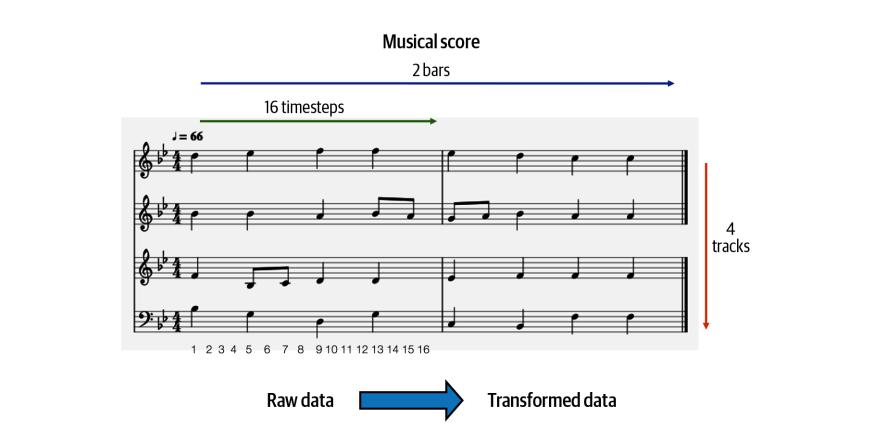

In [8]:
data_binary = np.eye(N_PITCHES)[two_bars]
data_binary[data_binary == 0] = -1
data_binary = data_binary.transpose([0, 1, 2, 4, 3])
print(f"Data binary shape {data_binary.shape}")

Data binary shape (229, 2, 16, 84, 4)


# The MuseGAN Generator

Like all GANs, MuseGAN consists of a generator and a critic. The generator tries to
fool the critic with its musical creations, and the critic tries to prevent this from hap‐
pening by ensuring it is able to tell the difference between the generator’s forged Bach
chorales and the real thing.

Where MuseGAN differs is in the fact that the generator doesn’t just accept a single
noise vector as input, but instead has four separate inputs, which correspond to four
different characteristics of the music: chords, style, melody, and groove. By manipu‐
lating each of these inputs independently we can change high-level properties of the
generated music.

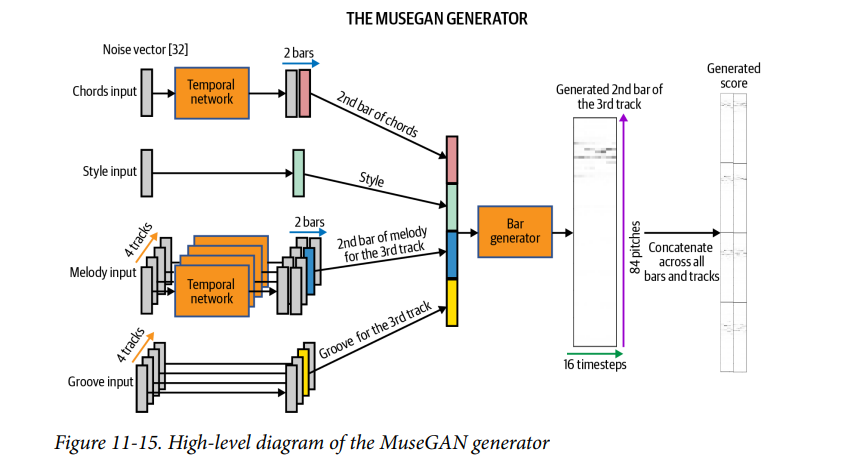

The diagram shows how the chords and melody inputs are first passed through a
temporal network that outputs a tensor with one of the dimensions equal to the num‐
ber of bars to be generated. The style and groove inputs are not stretched temporally
in this way, as they remain constant through the piece.

In [9]:
# Some helper functions

initializer = initializers.RandomNormal(mean=0.0, stddev=0.02)


def conv(x, f, k, s, p):
    x = layers.Conv3D(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    x = layers.LeakyReLU()(x)
    return x


def conv_t(x, f, k, s, a, p, bn):
    x = layers.Conv2DTranspose(
        filters=f,
        kernel_size=k,
        padding=p,
        strides=s,
        kernel_initializer=initializer,
    )(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)

    x = layers.Activation(a)(x)
    return x

The job of a temporal network—a neural network consisting of convolutional trans‐
pose layers—is to transform a single input noise vector of length Z_DIM = 32 into a
different noise vector for every bar (also of length 32)

The reason we use convolutional operations rather than requiring two independent
vectors into the network is because we would like the network to learn how one bar
should follow on from another in a consistent way. Using a neural network to expand
the input vector along the time axis means the model has a chance to learn how
music flows across bars, rather than treating each bar as completely independent of
the last.


In [10]:
def TemporalNetwork():
    input_layer = layers.Input(shape=(Z_DIM,), name="temporal_input")
    x = layers.Reshape([1, 1, Z_DIM])(input_layer)
    x = conv_t(x, f=1024, k=(2, 1), s=(1, 1), a="relu", p="valid", bn=True)
    x = conv_t(
        x, f=Z_DIM, k=(N_BARS - 1, 1), s=(1, 1), a="relu", p="valid", bn=True
    )
    output_layer = layers.Reshape([N_BARS, Z_DIM])(x)
    return models.Model(input_layer, output_layer)


TemporalNetwork().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer  [(None, 32)]              0         
 )                                                               
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 1, 1024)        66560     
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 2, 1, 1024)        4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                             

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


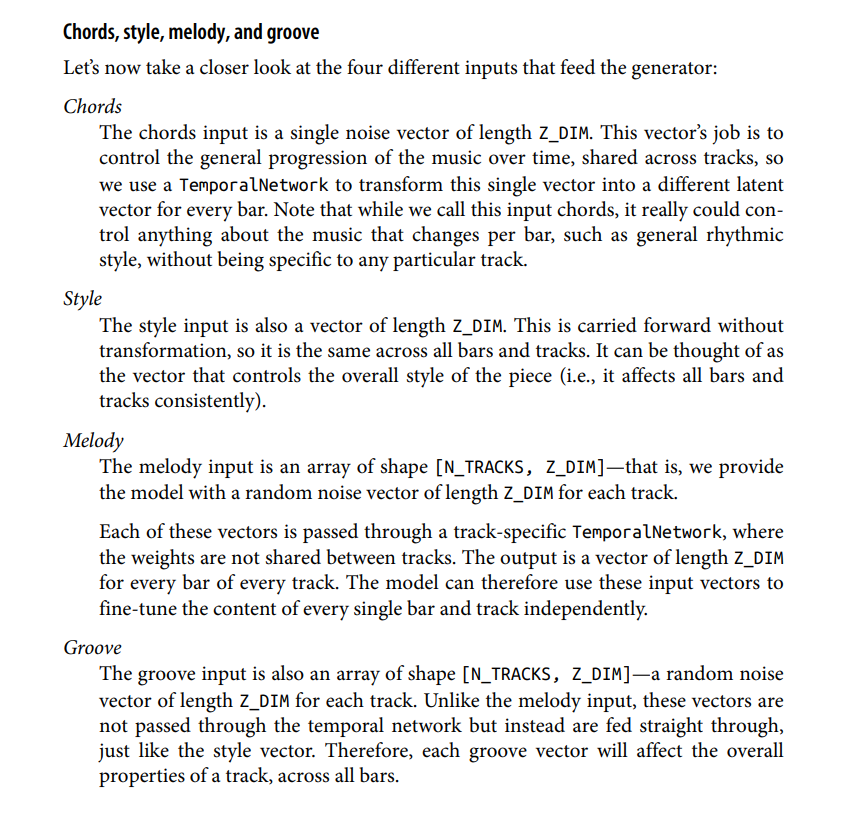

The bar generator receives four latent vectors—one from each of the chord, style,
melody, and groove components. These are concatenated to produce a vector of
length 4 * Z_DIM as input. The output is a piano roll representation of a single bar
for a single track—i.e., a tensor of shape [1, n_steps_per_bar, n_pitches, 1].

In [11]:
def BarGenerator():
    input_layer = layers.Input(shape=(Z_DIM * 4,), name="bar_generator_input")

    x = layers.Dense(1024)(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.Activation("relu")(x)
    x = layers.Reshape([2, 1, 512])(x)

    x = conv_t(x, f=512, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(2, 1), s=(2, 1), a="relu", p="same", bn=True)
    x = conv_t(x, f=256, k=(1, 7), s=(1, 7), a="relu", p="same", bn=True)
    x = conv_t(x, f=1, k=(1, 12), s=(1, 12), a="tanh", p="same", bn=False)

    output_layer = layers.Reshape([1, N_STEPS_PER_BAR, N_PITCHES, 1])(x)

    return models.Model(input_layer, output_layer)


BarGenerator().summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (Input  [(None, 128)]             0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 reshape_2 (Reshape)         (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 4, 1, 512)         5248

The input to the bar generator is a vector of length 4 * Z_DIM.


After passing it through a Dense layer, we reshape the tensor to prepare it for the
convolutional transpose operations.


First we expand the tensor along the timestep axis…


…then along the pitch axis.


The final layer has a tanh activation applied, as we will be using a WGAN-GP
(which requires tanh output activation) to train the network.


The tensor is reshaped to add two extra dimensions of size 1, to prepare it for
concatenation with other bars and tracks.


In [12]:
def Generator():
    chords_input = layers.Input(shape=(Z_DIM,), name="chords_input")
    style_input = layers.Input(shape=(Z_DIM,), name="style_input")
    melody_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="melody_input")
    groove_input = layers.Input(shape=(N_TRACKS, Z_DIM), name="groove_input")

    # CHORDS -> TEMPORAL NETWORK
    chords_tempNetwork = TemporalNetwork()
    chords_over_time = chords_tempNetwork(chords_input)  # [n_bars, z_dim]

    # MELODY -> TEMPORAL NETWORK
    melody_over_time = [
        None
    ] * N_TRACKS  # list of n_tracks [n_bars, z_dim] tensors
    melody_tempNetwork = [None] * N_TRACKS
    for track in range(N_TRACKS):
        melody_tempNetwork[track] = TemporalNetwork()
        melody_track = layers.Lambda(lambda x, track=track: x[:, track, :])(
            melody_input
        )
        melody_over_time[track] = melody_tempNetwork[track](melody_track)

    # CREATE BAR GENERATOR FOR EACH TRACK
    barGen = [None] * N_TRACKS
    for track in range(N_TRACKS):
        barGen[track] = BarGenerator()

    # CREATE OUTPUT FOR EVERY TRACK AND BAR
    bars_output = [None] * N_BARS
    c = [None] * N_BARS
    for bar in range(N_BARS):
        track_output = [None] * N_TRACKS

        c[bar] = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
            chords_over_time
        )  # [z_dim]
        s = style_input  # [z_dim]

        for track in range(N_TRACKS):
            m = layers.Lambda(lambda x, bar=bar: x[:, bar, :])(
                melody_over_time[track]
            )  # [z_dim]
            g = layers.Lambda(lambda x, track=track: x[:, track, :])(
                groove_input
            )  # [z_dim]

            z_input = layers.Concatenate(
                axis=1, name="total_input_bar_{}_track_{}".format(bar, track)
            )([c[bar], s, m, g])

            track_output[track] = barGen[track](z_input)

        bars_output[bar] = layers.Concatenate(axis=-1)(track_output)

    generator_output = layers.Concatenate(axis=1, name="concat_bars")(
        bars_output
    )

    return models.Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output,
    )


generator = Generator()
generator.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 melody_input (InputLayer)   [(None, 4, 32)]              0         []                            
                                                                                                  
 chords_input (InputLayer)   [(None, 32)]                 0         []                            
                                                                                                  
 lambda (Lambda)             (None, 32)                   0         ['melody_input[0][0]']        
                                                                                                  
 lambda_1 (Lambda)           (None, 32)                   0         ['melody_input[0][0]']        
                                                                                           

Define the inputs to the generator.

Pass the chords input through the temporal network.

Pass the melody input through the temporal network.

Create an independent bar generator network for every track.

Loop over the tracks and bars, creating a generated bar for each combination.

Concatenate everything together to form a single output tensor.

The MuseGAN model takes four distinct noise tensors as input and outputs a
generated multitrack, multibar score.


# The MuseGan Critic

In comparison to the generator, the critic architecture is much more straightforward
(as is often the case with GANs).
The critic tries to distinguish full multitrack, multibar scores created by the generator
from real excerpts from the Bach chorales. It is a convolutional neural network, consisting mostly of Conv3D layers that collapse the score into a single output prediction.

In [13]:
def Critic():
    critic_input = layers.Input(
        shape=(N_BARS, N_STEPS_PER_BAR, N_PITCHES, N_TRACKS),
        name="critic_input",
    )

    x = critic_input

    x = conv(x, f=128, k=(2, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(N_BARS - 1, 1, 1), s=(1, 1, 1), p="valid")
    x = conv(x, f=128, k=(1, 1, 12), s=(1, 1, 12), p="same")
    x = conv(x, f=128, k=(1, 1, 7), s=(1, 1, 7), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=128, k=(1, 2, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=256, k=(1, 4, 1), s=(1, 2, 1), p="same")
    x = conv(x, f=512, k=(1, 3, 1), s=(1, 2, 1), p="same")

    x = layers.Flatten()(x)

    x = layers.Dense(1024, kernel_initializer=initializer)(x)
    x = layers.LeakyReLU()(x)

    critic_output = layers.Dense(
        1, activation=None, kernel_initializer=initializer
    )(x)

    return models.Model(critic_input, critic_output)


critic = Critic()
critic.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 critic_input (InputLayer)   [(None, 2, 16, 84, 4)]    0         
                                                                 
 conv3d (Conv3D)             (None, 1, 16, 84, 128)    1152      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 16, 84, 128)    16512     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1, 16, 84, 128)    0         
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 16, 7, 128)     196736    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1, 16, 7, 128)     0  

In [14]:
class MuseGAN(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(MuseGAN, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(MuseGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            chords_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            style_random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            melody_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )
            groove_random_latent_vectors = tf.random.normal(
                shape=(batch_size, N_TRACKS, self.latent_dim)
            )

            random_latent_vectors = [
                chords_random_latent_vectors,
                style_random_latent_vectors,
                melody_random_latent_vectors,
                groove_random_latent_vectors,
            ]

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        chords_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(batch_size, N_TRACKS, self.latent_dim)
        )

        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]

        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

    def generate_piano_roll(self, num_scores):
        chords_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        style_random_latent_vectors = tf.random.normal(
            shape=(num_scores, Z_DIM)
        )
        melody_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        groove_random_latent_vectors = tf.random.normal(
            shape=(num_scores, N_TRACKS, Z_DIM)
        )
        random_latent_vectors = [
            chords_random_latent_vectors,
            style_random_latent_vectors,
            melody_random_latent_vectors,
            groove_random_latent_vectors,
        ]
        generated_music = self.generator(random_latent_vectors)
        generated_music = generated_music.numpy()
        return generated_music

In [15]:
# Create a MuseGAN
musegan = MuseGAN(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [16]:
# Compile the GAN
musegan.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=CRITIC_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=GENERATOR_LEARNING_RATE,
        beta_1=ADAM_BETA_1,
        beta_2=ADAM_BETA_2,
    ),
)

In [17]:
class MusicGenerator(callbacks.Callback):
    def __init__(self, num_scores):
        self.num_scores = num_scores

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            generated_music = self.model.generate_piano_roll(self.num_scores)
            notes_to_midi(
                generated_music,
                N_BARS,
                N_TRACKS,
                N_STEPS_PER_BAR,
                filename="output_" + str(epoch).zfill(4),
            )
            # display(generated_images, save_to = "./output/generated_img_%03d.png" % (epoch), cmap = None)


music_generator_callback = MusicGenerator(1)

In [19]:
history = musegan.fit(
    data_binary,
    epochs=EPOCHS,
    callbacks=[
        music_generator_callback,
    ],
)

Epoch 1/6000
8/8 [==============================] - 2s 257ms/step - c_loss: -66.9692 - c_wass_loss: -95.1060 - c_gp: 2.8137 - g_loss: -458.2069
Epoch 2/6000
8/8 [==============================] - 2s 258ms/step - c_loss: -41.8251 - c_wass_loss: -55.3308 - c_gp: 1.3506 - g_loss: -902.9402
Epoch 3/6000
8/8 [==============================] - 2s 260ms/step - c_loss: -57.2713 - c_wass_loss: -91.2546 - c_gp: 3.3983 - g_loss: -1021.3391
Epoch 4/6000
8/8 [==============================] - 2s 261ms/step - c_loss: -62.0650 - c_wass_loss: -89.2501 - c_gp: 2.7185 - g_loss: -577.7646
Epoch 5/6000
8/8 [==============================] - 2s 286ms/step - c_loss: -66.2966 - c_wass_loss: -102.6261 - c_gp: 3.6330 - g_loss: -423.3491
Epoch 6/6000
8/8 [==============================] - 2s 262ms/step - c_loss: -68.2111 - c_wass_loss: -98.2949 - c_gp: 3.0084 - g_loss: -371.6434
Epoch 7/6000
8/8 [==============================] - 2s 295ms/step - c_loss: -62.0042 - c_wass_loss: -87.4530 - c_gp: 2.5449 - g_loss: 

KeyboardInterrupt: 

One drawback to the model is that the number of
bars to generate must be specified up front. To tackle this, the authors show an exten‐
sion to the model that allows previous bars to be fed in as input, allowing the model
to generate long-form scores by continually feeding the most recent predicted bars
back in as additional input.

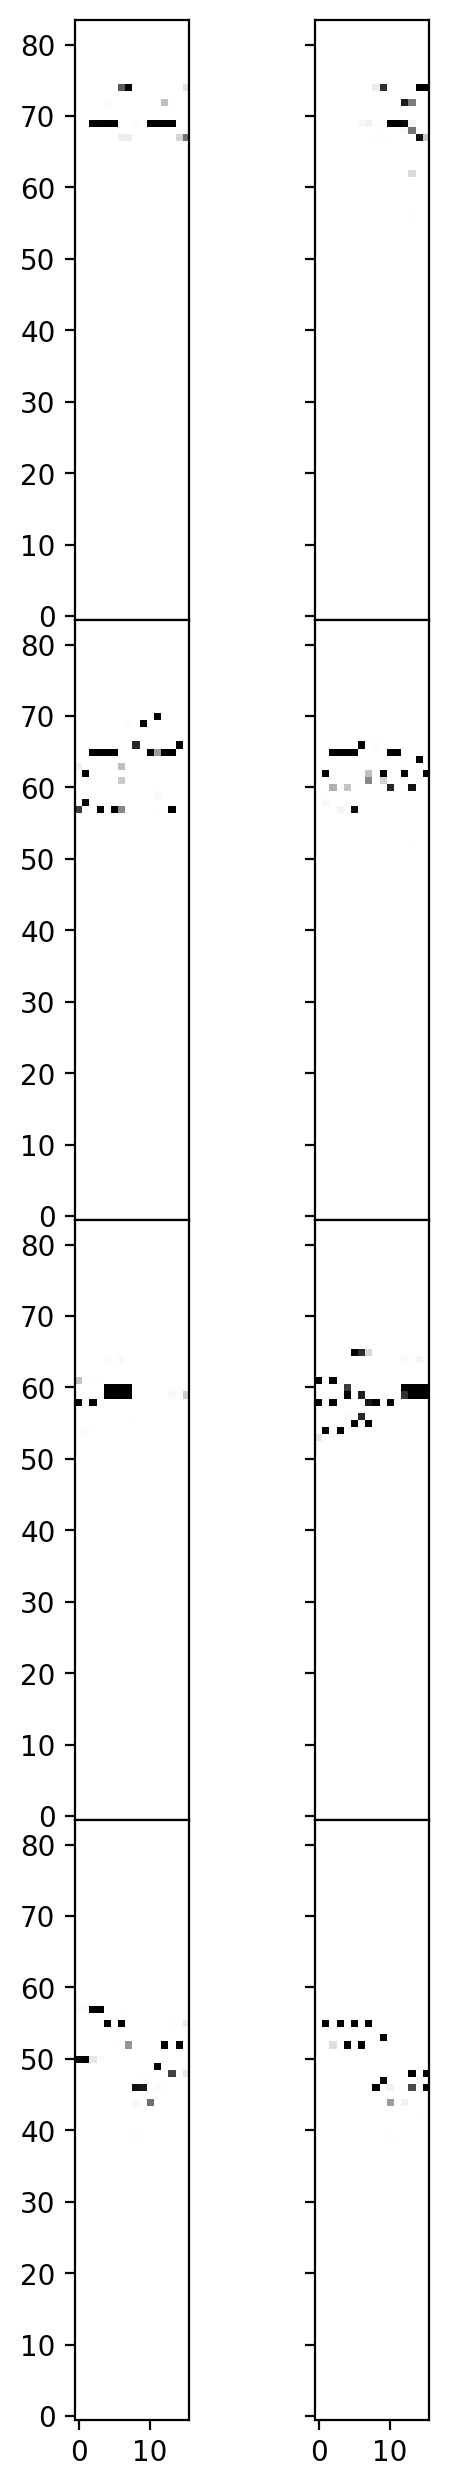

In [20]:
num_scores = 1
chords_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
style_random_latent_vectors = np.random.normal(size=(num_scores, Z_DIM))
melody_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
groove_random_latent_vectors = np.random.normal(
    size=(num_scores, N_TRACKS, Z_DIM)
)
random_latent_vectors = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music = generator(random_latent_vectors)
generated_music = generated_music.numpy()

draw_score(generated_music, 0)
notes_to_midi(
    generated_music, N_BARS, N_TRACKS, N_STEPS_PER_BAR, filename="output_midi"
)

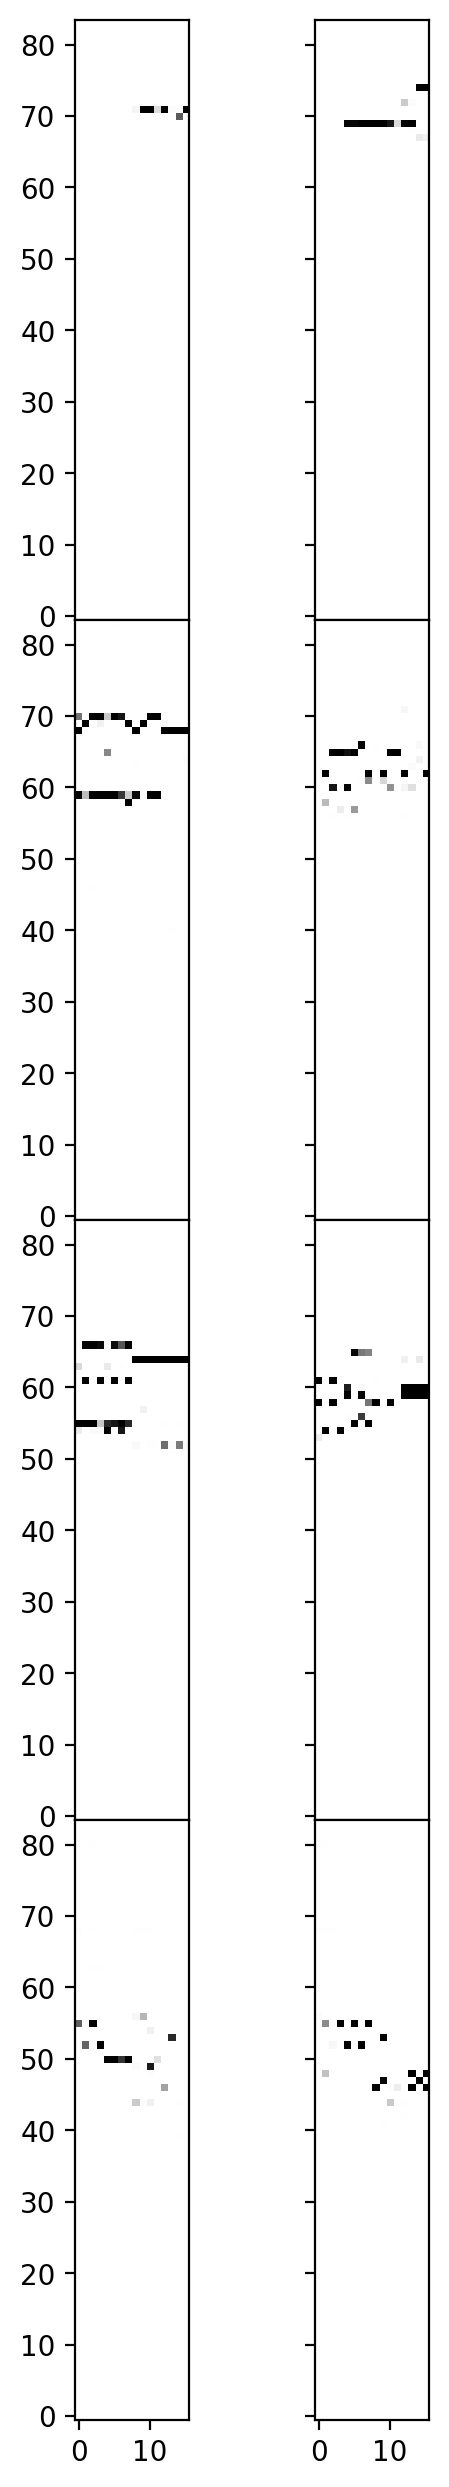

In [21]:
# Changing Chord Noise
chords_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_2 = [
    chords_random_latent_vectors_2,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_2 = generator(random_latent_vectors_2)
generated_music_2 = generated_music_2.numpy()
draw_score(generated_music_2, 0)
notes_to_midi(
    generated_music_2,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_chords_changed",
)

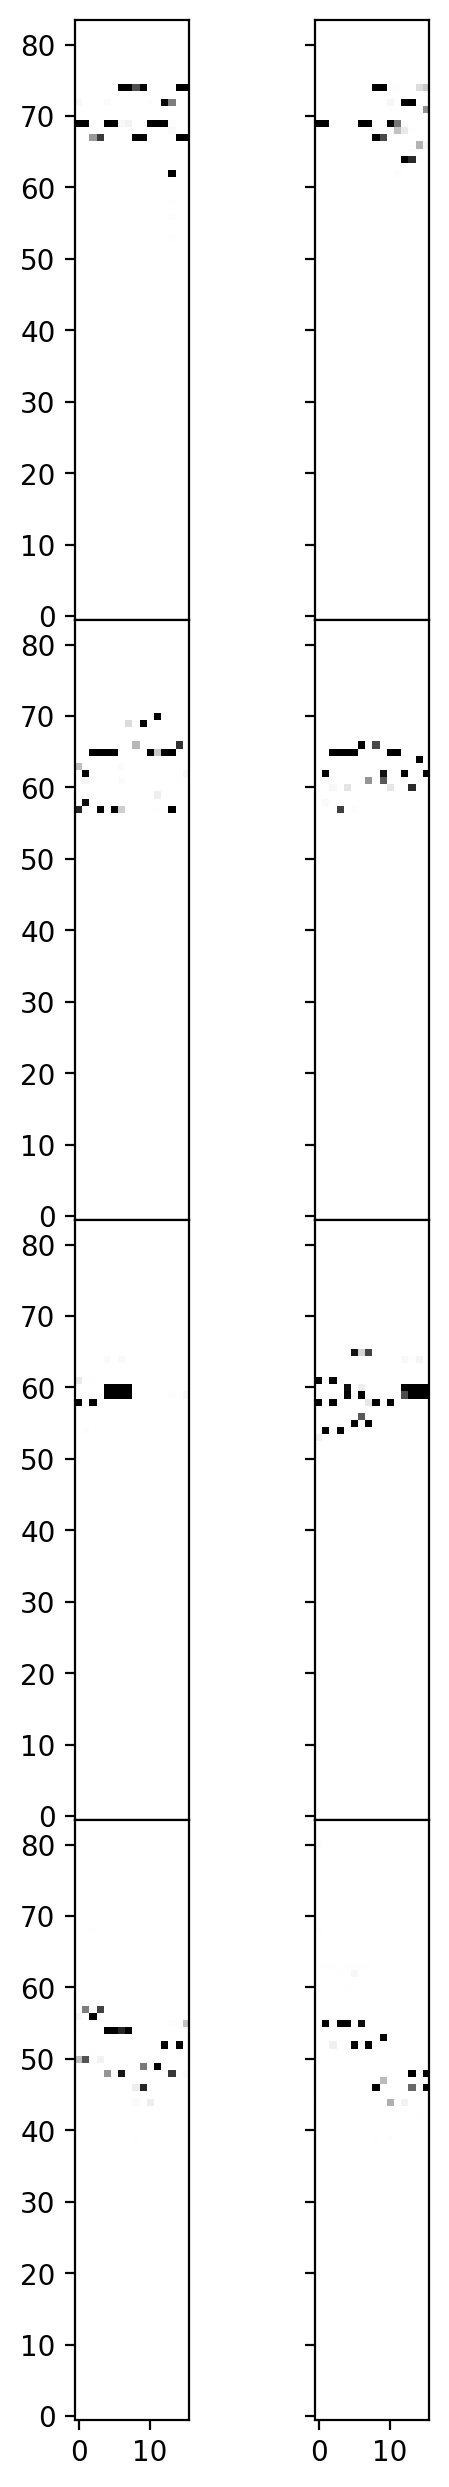

In [22]:
# Changing Style Noise
style_random_latent_vectors_2 = np.random.normal(size=(num_scores, Z_DIM))
random_latent_vectors_3 = [
    chords_random_latent_vectors,
    style_random_latent_vectors_2,
    melody_random_latent_vectors,
    groove_random_latent_vectors,
]
generated_music_3 = generator(random_latent_vectors_3)
generated_music_3 = generated_music_3.numpy()
draw_score(generated_music_3, 0)
notes_to_midi(
    generated_music_3,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_style_changed",
)

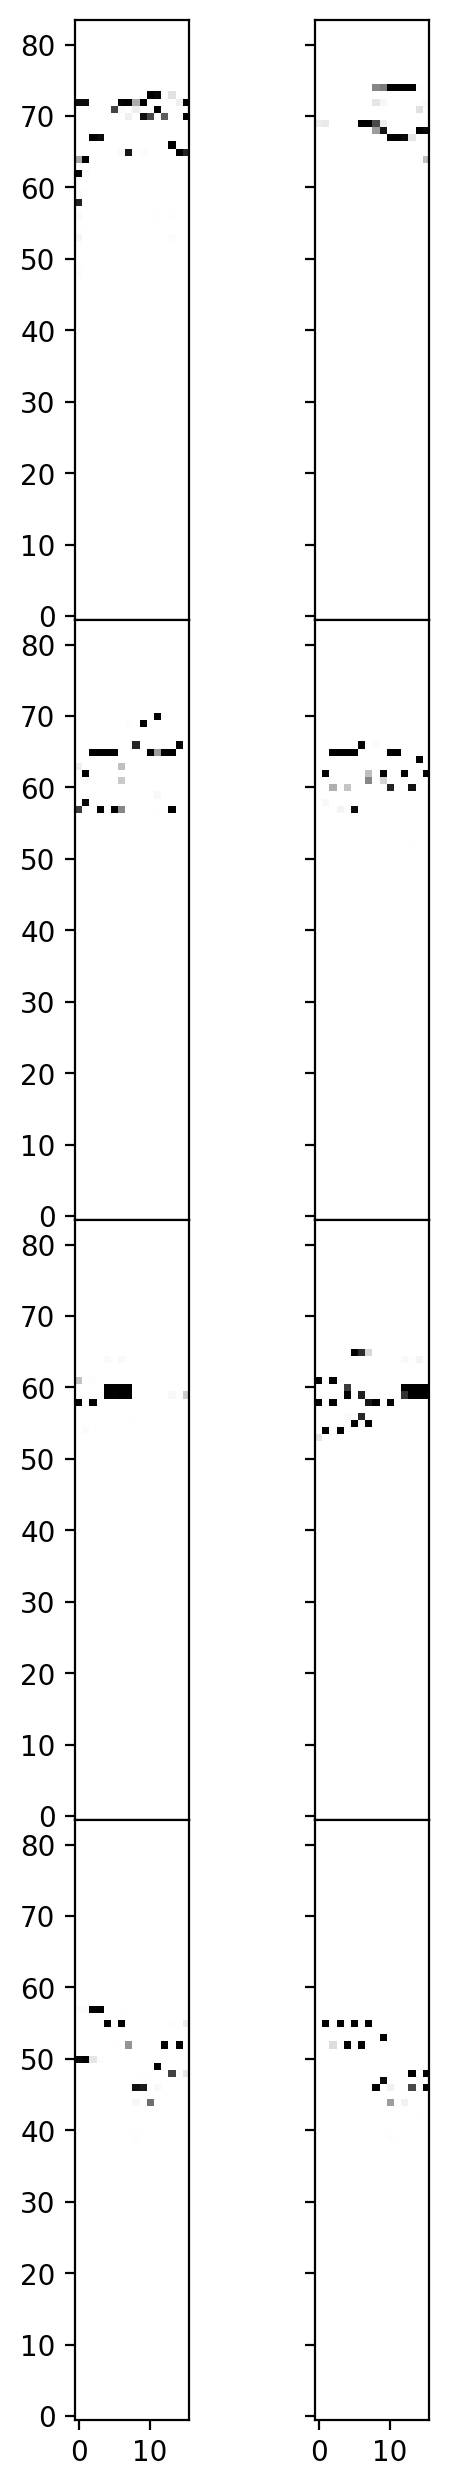

In [23]:
# Changing Melody Noise
melody_random_latent_vectors_2 = np.copy(melody_random_latent_vectors)
melody_random_latent_vectors_2[:, 0, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_4 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors_2,
    groove_random_latent_vectors,
]
generated_music_4 = generator(random_latent_vectors_4)
generated_music_4 = generated_music_4.numpy()
draw_score(generated_music_4, 0)
notes_to_midi(
    generated_music_4,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_melody_changed",
)

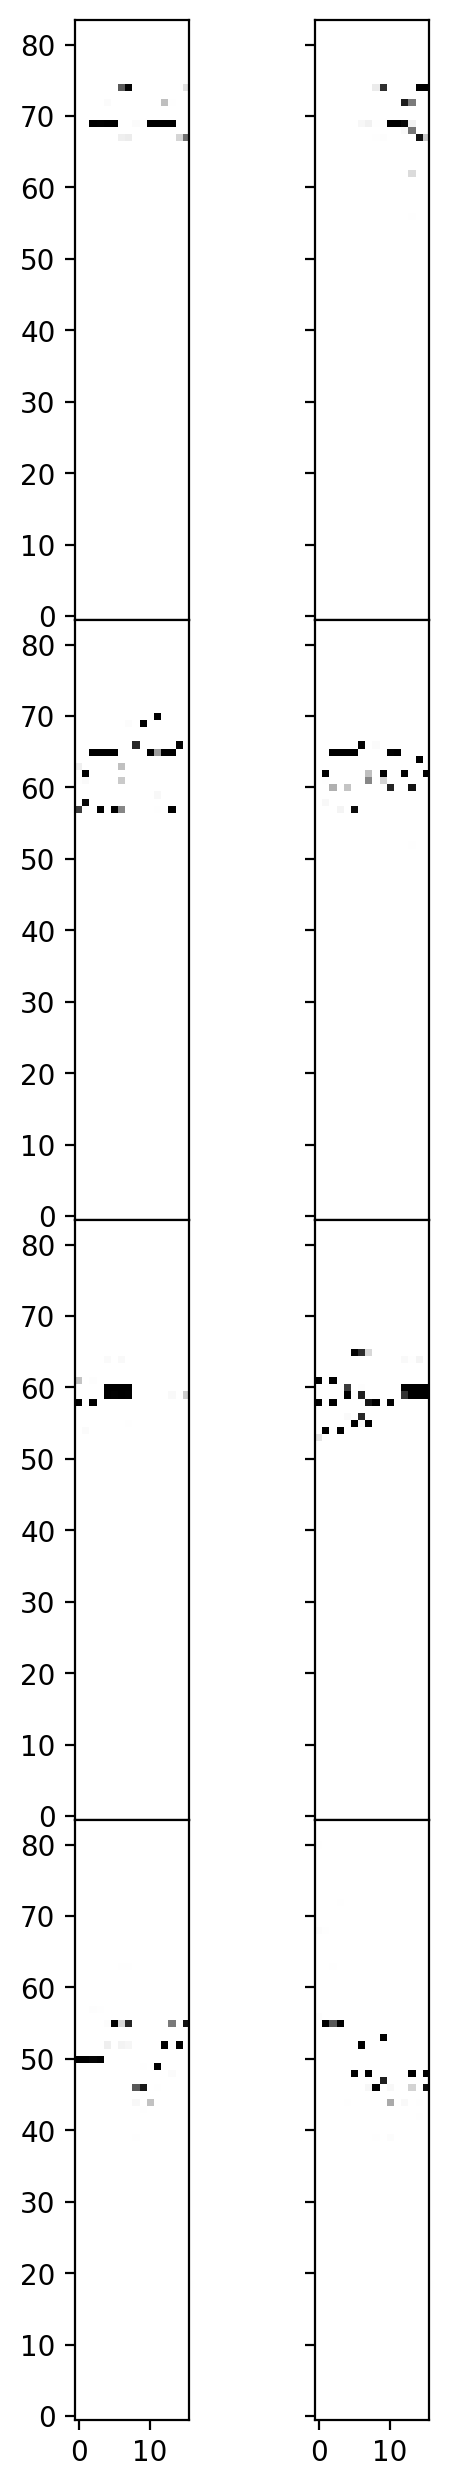

In [24]:
# Changing groove noise
groove_random_latent_vectors_2 = np.copy(groove_random_latent_vectors)
groove_random_latent_vectors_2[:, -1, :] = np.random.normal(
    size=(num_scores, Z_DIM)
)

random_latent_vectors_5 = [
    chords_random_latent_vectors,
    style_random_latent_vectors,
    melody_random_latent_vectors,
    groove_random_latent_vectors_2,
]
generated_music_5 = generator(random_latent_vectors_5)
generated_music_5 = generated_music_5.numpy()
draw_score(generated_music_5, 0)
notes_to_midi(
    generated_music_5,
    N_BARS,
    N_TRACKS,
    N_STEPS_PER_BAR,
    filename="output_midi_groove_changed",
)